In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

logging.getLogger('jieba').setLevel(logging.WARN)
logging.getLogger('fgclassifier').setLevel(logging.INFO)

In [2]:
import os

os.chdir('..')

In [3]:
import sklearn
sklearn.__version__

'0.20.1'

In [4]:
from sklearn.externals import joblib

results = joblib.load('data/model-selection-zh.pkl')

# Model Selection

## Baseline Models

This notebook shows how to use our baseline model.
It also demonstrates how to test different feature models (i.e.,
different ways of building the features) at the same time.

We will use mostly the Google Translated English dataset for this
demonstration purpose.

In [5]:
import config
from collections import defaultdict
from sklearn.model_selection import train_test_split
from fgclassifier.utils import read_data, get_dataset

df_train = get_dataset('train')
df_valid = get_dataset('valid')
df_testa = get_dataset('testa')

2018-12-07 17:47:37,640 [INFO] Reading /opt/storage/chinese_train.csv.tokenized.csv..
2018-12-07 17:47:37,975 [INFO] Reading /opt/storage/chinese_train.csv..
2018-12-07 17:47:38,198 [INFO] Reading /opt/storage/chinese_valid.csv.tokenized.csv..
2018-12-07 17:47:38,277 [INFO] Reading /opt/storage/chinese_valid.csv..
2018-12-07 17:47:38,345 [INFO] Reading /opt/storage/test-a/sentiment_analysis_testa.csv.tokenized.csv..
2018-12-07 17:47:38,698 [INFO] Reading /opt/storage/test-a/sentiment_analysis_testa.csv..


In [7]:
df_train_train = df_train.sample(8000, random_state=1)
df_valid_valid = df_valid.sample(2000, random_state=1)
df_test_test = df_testa.sample(2000, random_state=1)
display(df_test_test['content'].head(2))
display(df_test_test['content_raw'].head(2))

7576     第一次 抽到 霸王餐 ， 跟 老妈 一起 改善 伙食 ！ 有 打电话 预约 ， 说 可以 直...
10509    位置 】 一不留神 江宁 龙眠 大道 地铁站 附近 、 义务 小商品 城 对面 又 开 一家...
Name: content, dtype: object

7576     第一次抽到霸王餐，跟老妈一起改善伙食！有打电话预约，说可以直接去，周六中午去的，饭堂挺大，跟...
10509    【位置】一不留神江宁龙眠大道地铁站附近、义务小商品城的对面又开了一家日式料理店，旁边还有诺大...
Name: content_raw, dtype: object

In [8]:
import csv

df_train_train.drop(['content_raw'], axis=1).to_csv(
    'data/chinese_train.csv.tokenized.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
df_valid_valid.drop(['content_raw'], axis=1).to_csv(
    'data/chinese_valid.csv.tokenized.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
df_test_test.drop(['content_raw'], axis=1).to_csv(
    'data/chinese_test.csv.tokenized.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [9]:
# df_train_train['content'] = df_train_train['content_raw']
# df_valid_valid['content'] = df_valid_valid['content_raw']
# df_test_test['content'] = df_test_test['content_raw']

# df_train_train.drop(['content_raw'], axis=1).to_csv(
#     'data/chinese_train.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
# df_valid_valid.drop(['content_raw'], axis=1).to_csv(
#     'data/chinese_valid.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
# df_test_test.drop(['content_raw'], axis=1).to_csv(
#     'data/chinese_test.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [10]:
X_train, y_train = read_data(df_train_train)
X_test, y_test = read_data(df_valid_valid)

In [5]:
# del fm['tfidf_sv']
# del fm['tfidf_sv_dense']
# del fm['lsa_200_sv']
# del fm['lsa_500_sv']
# del fm['count_tiny']

In [6]:
# Cache feature models and trained fetures, we make this cache object
# so different steps can reuse previously transformed features
fm = defaultdict(dict)

In [7]:
from fgclassifier.features import FeaturePipeline, logger

def build_features(fm_names, fm):
    for name in fm_names:
        logger.info(f'Building features for {name}...')
        model = FeaturePipeline.from_spec(name, cache=fm)
        model.fit_transform(X_train)
        model.transform(X_test)
    
build_features(['count', 'count_sv'], fm)

C:\Users\jyyjc\Anaconda3\envs\idp\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
2018-12-05 20:15:46,158 [INFO] 'pattern' package not found; tag filters are not available for English
2018-12-05 20:15:46,171 [INFO] Building features for count...
2018-12-05 20:17:19,771 [INFO] Vocab Size: 4000
2018-12-05 20:17:21,344 [INFO] Building features for count_sv...
2018-12-05 20:18:45,679 [INFO] Vocab Size: 2000


Exam the quality of the top terms:

In [8]:
from collections import Counter

print('Data Shape:', X_train.shape, X_test.shape)

for mn in ['count', 'count_sv']:
    model = fm[mn]['model'].named_steps[mn]
    key = next(filter(lambda x: 'fit_transform' in x, fm[mn].keys()))
    x_train = fm[mn][key]
    counts = np.sum(x_train, axis=0).flat
    counts = {k: counts[v] for k, v in model.vocabulary_.items()}
    print('\nmin_df: %.3f, max_df: %.3f, ngram_range: %s' % (
        model.min_df, model.max_df, model.ngram_range
    ))
    
    print('\nvocab size: %s\n' % len(model.vocabulary_))
    if model.stop_words_:
        print('\nStop words size: %s\n' % len(model.stop_words_))
    
    # Remove stop words as they take a lot of memory
    model.stop_words_ = None
    
    print('\n'.join([
        '%s \t %s' % (k, v)
        for k, v in Counter(counts).most_common()[:5]]))

Data Shape: (20000,) (2000,)

min_df: 5.000, max_df: 0.900, ngram_range: (1, 5)

vocab size: 4000


Stop words size: 11046160

是 	 63179
很 	 55245
吃 	 46324
也 	 42235
！ 	 37043

min_df: 5.000, max_df: 0.600, ngram_range: (1, 5)

vocab size: 2000


Stop words size: 11048160

！ 	 37043
我 	 28804
和 	 22049
感觉 	 17275
可以 	 17024


Save the word count features, as it is pretty slow to run for the whole dataset...

In [9]:
from sklearn.externals import joblib


def partial_get(d, keyword):
    key = next(filter(lambda x: x.startswith(keyword), d.keys()))
    return d[key]

def save_transform_cache(mn, path=None):
    path = path or f'data/fm_cache-{mn}'
    Xtrain = partial_get(fm[mn], 'fit_transform')
    Xtest = partial_get(fm[mn], 'transform')
    joblib.dump(Xtrain, path + '-train.pkl')
    joblib.dump(Xtest, path + '-test.pkl')
    print(f'Saved {path}')
    
save_transform_cache('count')
save_transform_cache('count_sv')
joblib.load('data/fm_cache-count-test.pkl')

Saved data/fm_cache-count
Saved data/fm_cache-count_sv


<2000x4000 sparse matrix of type '<class 'numpy.int64'>'
	with 280293 stored elements in Compressed Sparse Row format>

Build more features

In [1]:
# build_features(['tfidf', 'tfidf_dense', 'lsa_500', 'lsa_1k'], fm)
# build_features(['tfidf_sv', 'tfidf_sv_dense', 'lsa_500_sv', 'lsa_1k_sv'], fm)
# build_features(['tfidf_tiny', 'tfidf_tiny_dense', 'lsa_500_tiny'], fm)
# build_features(['word2vec'], fm)

In [11]:
save_transform_cache('tfidf')
save_transform_cache('lsa_500')
save_transform_cache('lsa_1k')

save_transform_cache('tfidf_sv')
save_transform_cache('lsa_500_sv')
save_transform_cache('lsa_1k_sv')

# save_transform_cache('tfidf_tiny')
# save_transform_cache('lsa_500_tiny')
# save_transform_cache('lsa_1k_tiny')

save_transform_cache('word2vec')

Saved data/fm_cache-tfidf
Saved data/fm_cache-lsa_500
Saved data/fm_cache-lsa_1k
Saved data/fm_cache-tfidf_sv
Saved data/fm_cache-lsa_500_sv
Saved data/fm_cache-lsa_1k_sv
Saved data/fm_cache-word2vec


## The Very Basic TF-IDF + LDA classifier

In [12]:
# Impact all feature models at once, so to avoid
# classes being reloaded and causing save_model to fail
from fgclassifier.baseline import Baseline, Dummy
from fgclassifier.train import fm_cross_check

Check a basic model

In [13]:
model = Baseline('SGD_Logistic', fm=fm['lsa_1k']['model'])
# Always pass in the original features
# the pipeline will take care of the cache
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-05 20:22:21,999 [INFO]   lsa_1k: fit_transform use cache.
2018-12-05 20:22:48,195 [INFO]   lsa_1k: transform use cache.
2018-12-05 20:22:48,335 [INFO]  F1 Score: 0.48595313495018166


lsa_1k_SGD_Logistic final score: 0.48595313495018166


Logistic is much slower but performs not much better than Stochastic logistic.

In [14]:
model = Baseline('SGD_Huber', fm=fm['lsa_1k']['model'])
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-05 20:22:48,517 [INFO]   lsa_1k: fit_transform use cache.
2018-12-05 20:23:15,675 [INFO]   lsa_1k: transform use cache.
2018-12-05 20:23:15,851 [INFO]  F1 Score: 0.45909039192231227


lsa_1k_SGD_Huber final score: 0.45909039192231227


In [15]:
model = Baseline('SGD_SVC', fm=fm['lsa_1k']['model'])
model.fit(X_train, y_train)
print(f'{model.name} final score:', model.score(X_test, y_test))

2018-12-05 20:23:16,088 [INFO]   lsa_1k: fit_transform use cache.
2018-12-05 20:23:38,750 [INFO]   lsa_1k: transform use cache.
2018-12-05 20:23:38,886 [INFO]  F1 Score: 0.4860306699639442


lsa_1k_SGD_SVC final score: 0.4860306699639442


In [16]:
# model = Baseline('Ridge', fm=fm['lsa_1k']['model'])
# model.fit(X_train, y_train)
# print(f'{model.name} final score:', model.score(X_test, y_test))

## Search for the Best Feature + Classifier Combination

In [17]:
# Run for all classifiers and feature builders
train_avg_scores, train_scores = defaultdict(dict), defaultdict(dict)
test_avg_scores, test_scores = defaultdict(dict), defaultdict(dict)
test_time, train_time = defaultdict(dict), defaultdict(dict)

In [18]:
from fgclassifier import classifiers
from fgclassifier.baseline import Dummy

Dummy(classifiers.DummyStratified)

Dummy(classifier=None)

In [19]:
conf = {
    'fm_cache': fm,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'results': {
        'models': {},
        'test': test_scores,
        'test_time': test_time,
        'test_avg': test_avg_scores,
        'train': train_scores,
        'train_time': train_time,
        'train_avg': train_avg_scores
    }
}

In [20]:
from IPython.display import clear_output

# # We'd only need to run the dummy models on one feature model,
# # as they do not care about the features
fm_cross_check(
    ['count', 'count_sv',
     'tfidf', 'tfidf_sv'],
    ['DummyStratified', 'DummyMostFrequent'],
    model_cls=Dummy, **conf)

# # Naive Bayes models cannot handle negative values, so we pass
# # in only tfidf features
fm_cross_check(
    ['count', 'count_sv',
     'tfidf', 'tfidf_sv'],
    ['ComplementNB'], **conf)
clear_output()

In [21]:
# Only SGD methods can handle sparse matrix
fm_cross_check(
    [
     'tfidf', 'lsa_500', 'lsa_1k',
     'tfidf_sv', 'lsa_500_sv', 'lsa_1k_sv',
     'count', 'count_sv',
    ],
    ['SGD_Logistic', 'SGD_SVC'], **conf)

clear_output()

In [22]:
# All other models can run on many classifiers
results = fm_cross_check(
    ['lsa_500', 'lsa_1k',
     'lsa_500_sv', 'lsa_1k_sv'],
    ['LDA', 'Ridge'], **conf)

clear_output()

In [23]:
results = fm_cross_check(
    ['word2vec'],
    ['SGD_Logistic', 'SGD_SVC', 'LDA', 'Ridge'], **conf)

2018-12-05 20:40:50,367 [INFO] 
2018-12-05 20:40:50,368 [INFO] ============ Feature Model: word2vec ============
2018-12-05 20:40:50,369 [INFO] 
2018-12-05 20:40:50,370 [INFO] Train for word2vec -> SGD_Logistic...
2018-12-05 20:40:50,371 [INFO]   word2vec: fit_transform use cache.
2018-12-05 20:41:49,233 [INFO]   word2vec: transform use cache.
2018-12-05 20:41:49,356 [INFO] -------------------------------------------------------
2018-12-05 20:41:49,358 [INFO] 【word2vec -> SGD_Logistic】 Train: 0.4207, Test: 0.3986
2018-12-05 20:41:49,359 [INFO] -------------------------------------------------------
2018-12-05 20:41:49,360 [INFO] Train for word2vec -> SGD_SVC...
2018-12-05 20:41:49,361 [INFO]   word2vec: fit_transform use cache.
2018-12-05 20:41:59,108 [INFO]   word2vec: transform use cache.
2018-12-05 20:42:00,053 [INFO]   word2vec: transform use cache.
2018-12-05 20:42:00,165 [INFO] -------------------------------------------------------
2018-12-05 20:42:00,166 [INFO] 【word2vec -> SGD

In [24]:
results = fm_cross_check(
    ['tfidf_sv_dense'],
    ['LDA', 'Ridge'], **conf)

2018-12-05 20:43:01,670 [INFO] 
2018-12-05 20:43:01,671 [INFO] ============ Feature Model: tfidf_sv_dense ============
2018-12-05 20:43:01,673 [INFO] 
2018-12-05 20:43:01,674 [INFO] Train for tfidf_sv_dense -> LDA...
2018-12-05 20:43:01,675 [INFO]   tfidf_sv_dense: fit_transform use cache.
2018-12-05 20:49:46,685 [INFO]   tfidf_sv: transform use cache.
2018-12-05 20:49:49,119 [INFO]   tfidf_sv_dense: transform use cache.
2018-12-05 20:49:49,349 [INFO] -------------------------------------------------------
2018-12-05 20:49:49,350 [INFO] 【tfidf_sv_dense -> LDA】 Train: 0.6955, Test: 0.5035
2018-12-05 20:49:49,351 [INFO] -------------------------------------------------------
2018-12-05 20:49:49,352 [INFO] Train for tfidf_sv_dense -> Ridge...
2018-12-05 20:49:49,354 [INFO]   tfidf_sv_dense: fit_transform use cache.
2018-12-05 20:57:47,291 [INFO]   tfidf_sv_dense: transform use cache.
C:\Users\jyyjc\Anaconda3\envs\idp\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetri

In [25]:
# This is very slow ...
results = fm_cross_check(
    ['tfidf_dense'],
    ['LDA', 'Ridge'], **conf)

2018-12-05 20:57:50,063 [INFO] 
2018-12-05 20:57:50,064 [INFO] ============ Feature Model: tfidf_dense ============
2018-12-05 20:57:50,064 [INFO] 
2018-12-05 20:57:50,066 [INFO] Train for tfidf_dense -> LDA...
2018-12-05 20:57:50,067 [INFO]   tfidf_dense: fit_transform use cache.
C:\Users\jyyjc\Anaconda3\envs\idp\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\jyyjc\Anaconda3\envs\idp\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\jyyjc\Anaconda3\envs\idp\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\jyyjc\Anaconda3\envs\idp\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\jyyjc\Anaconda3\envs\

In [23]:
# Boosting is too damn slow...
# results = fm_cross_check(
#     ['lsa_500',
#      'lsa_500_sv',
#      'lsa_500_tiny',
#      'lsa_1k',
#      'word2vec',
#     ],
#     ['XGB', 'AdaBoost', 'GradientBoost'], **conf)
# clear_output()

In [11]:
import pandas as pd


def merge_dense(obj):
    obj = obj.copy()
    obj['tfidf'] = {
        **obj['tfidf_dense'],
        **obj['tfidf']
    }
    obj['tfidf_sv'] = {
        **obj['tfidf_sv_dense'],
        **obj['tfidf_sv']
    }
    del obj['tfidf_dense']
    del obj['tfidf_sv_dense']
    return obj

def extract_scores(scores, avg_scores):
    scores = merge_dense(scores)
    avg_scores = merge_dense(avg_scores)
    rows = {}
    for fm_name in scores:
        for clf_name in avg_scores[fm_name]:
            key = f'{fm_name}.{clf_name}'
            rows[key] = [avg_scores[fm_name][clf_name], *scores[fm_name][clf_name]]
    df = pd.DataFrame(rows)
    df.index = ['average', *y_train.columns]
    return df.T.sort_values('average', ascending=False)

df_train = extract_scores(results['train'], results['train_avg'])
df_test = extract_scores(results['test'], results['test_avg'])
df_test

,average,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
tfidf.SGD_SVC,0.489795,0.454481,0.332446,0.491820,0.437609,0.601185,0.460738,0.498250,0.541640,0.461819,...,0.479864,0.527874,0.505368,0.499980,0.492363,0.534240,0.403551,0.522764,0.489177,0.511281
tfidf_sv.SGD_SVC,0.485976,0.484695,0.349542,0.488639,0.463949,0.582835,0.444061,0.513078,0.518620,0.482393,...,0.483864,0.548889,0.504037,0.512662,0.465865,0.520124,0.384468,0.456907,0.472649,0.496588
tfidf_sv.SGD_Logistic,0.481816,0.441332,0.332622,0.486173,0.431565,0.603176,0.399866,0.515237,0.534877,0.444846,...,0.492842,0.526994,0.484130,0.499887,0.486215,0.563688,0.406090,0.442718,0.509418,0.509445
lsa_1k.LDA,0.480478,0.417291,0.339043,0.495739,0.450342,0.587103,0.477025,0.500050,0.518758,0.464979,...,0.448284,0.492853,0.474880,0.474272,0.458206,0.548583,0.401796,0.502803,0.512260,0.514168
tfidf.SGD_Logistic,0.474229,0.412907,0.313088,0.441457,0.407049,0.589092,0.416668,0.474110,0.530431,0.473495,...,0.489823,0.524729,0.482002,0.479120,0.477235,0.556494,0.403010,0.459272,0.498853,0.508996
tfidf_tiny_dense.LDA,0.468857,0.476830,0.334322,0.521752,0.468711,0.576390,0.474247,0.471370,0.480514,0.489135,...,0.452438,0.459793,0.470952,0.463497,0.463351,0.480427,0.355560,0.409849,0.481175,0.506026
lsa_500.LDA,0.464987,0.431697,0.331870,0.484233,0.433379,0.584557,0.394787,0.470415,0.494115,0.444043,...,0.486805,0.482176,0.463426,0.462501,0.452025,0.527255,0.384982,0.462963,0.490531,0.479240
tfidf_tiny.SGD_Logistic,0.463661,0.434263,0.335465,0.499371,0.411131,0.589900,0.439388,0.464687,0.497679,0.423394,...,0.473929,0.461286,0.474509,0.484046,0.476720,0.519083,0.364888,0.395902,0.470996,0.519753
tfidf_tiny.SGD_SVC,0.462867,0.465652,0.338041,0.505843,0.421339,0.593026,0.446320,0.462928,0.493627,0.451105,...,0.455579,0.456619,0.457755,0.469622,0.475524,0.502683,0.369668,0.402893,0.449972,0.493351
lsa_500_sv.LDA,0.460318,0.432554,0.329587,0.496804,0.452181,0.590158,0.371347,0.481463,0.486450,0.430205,...,0.474288,0.461873,0.442957,0.476594,0.453123,0.531066,0.363569,0.417685,0.488381,0.487020


In [27]:
# Save the results
results = conf['results'].copy()
del results['models']  # don't save models (which are huuuuge)
joblib.dump(results, 'data/model-selection-zh.pkl')

['data/model-selection-zh.pkl']

In [15]:
# important columns
imp_cols = ['count', 'count_sv', 'tfidf', 'tfidf_sv', 'lsa_500', 'lsa_500_sv', 'lsa_1k', 'lsa_1k_sv', 'word2vec']

def extract_avg_scores(scores):
    scores = merge_dense(scores)
    df = pd.DataFrame(scores)
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df = df.sort_values(by='avg', axis=1, ascending=False)
    df = df.sort_values(by='avg', ascending=False)
    df = df.drop(['avg'], axis=1)
    df = df.drop(['avg'], axis=0)
    return df[imp_cols]

# df_train_avg = extract_avg_scores(results['train_avg'])
# df_test_avg = extract_avg_scores(results['test_avg'])
# df_test_avg

In [29]:
def extract_running_time(times):
    df = pd.DataFrame(times)
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df['avg'] = df.mean(axis=1, skipna=True)
    df = df.T
    df = df.sort_values(by='avg', axis=1, ascending=True)
    df = df.sort_values(by='avg', ascending=True)
    df = df.drop(['avg'], axis=1)
    df = df.drop(['avg'], axis=0)
    return df[imp_cols]
    
df_train_time = extract_running_time(train_time)
df_test_time = extract_running_time(test_time)
df_train_time

,count,count_sv,tfidf,tfidf_sv,lsa_500,lsa_500_sv,lsa_1k,lsa_1k_sv,word2vec
DummyMostFrequent,0.150026,0.147998,0.146045,0.149032,NaN,NaN,NaN,NaN,NaN
DummyStratified,0.183026,0.176044,0.186996,0.198025,NaN,NaN,NaN,NaN,NaN
ComplementNB,17.684044,17.684887,0.977024,0.798025,NaN,NaN,NaN,NaN,NaN
SGD_SVC,6.774024,5.663027,7.032999,5.092995,16.790555,12.845002,24.712049,22.870994,10.693158
SGD_Logistic,7.593033,6.047002,7.126025,5.603993,17.054537,14.822027,28.575998,27.422833,58.863052
LDA,NaN,NaN,NaN,NaN,51.044068,49.354091,128.225261,127.241283,27.850026
Ridge,NaN,NaN,NaN,NaN,60.331308,59.403583,148.348552,148.787650,33.259542


In [30]:
df_test_time

,count,count_sv,tfidf,tfidf_sv,lsa_500,lsa_500_sv,lsa_1k,lsa_1k_sv,word2vec
DummyMostFrequent,0.020002,0.020994,0.020949,0.029972,NaN,NaN,NaN,NaN,NaN
DummyStratified,0.023007,0.022000,0.024004,0.023002,NaN,NaN,NaN,NaN,NaN
ComplementNB,0.072981,0.060948,0.049972,0.042010,NaN,NaN,NaN,NaN,NaN
SGD_SVC,0.064016,0.062020,0.062028,0.043045,0.085034,0.079026,0.126013,0.123048,0.111972
SGD_Logistic,0.067962,0.066993,0.053029,0.043031,0.156998,0.082017,0.139030,0.132001,0.122971
Ridge,NaN,NaN,NaN,NaN,0.078999,0.095971,0.134970,0.129996,0.107016
LDA,NaN,NaN,NaN,NaN,0.079043,0.098033,0.133970,0.121015,0.104005


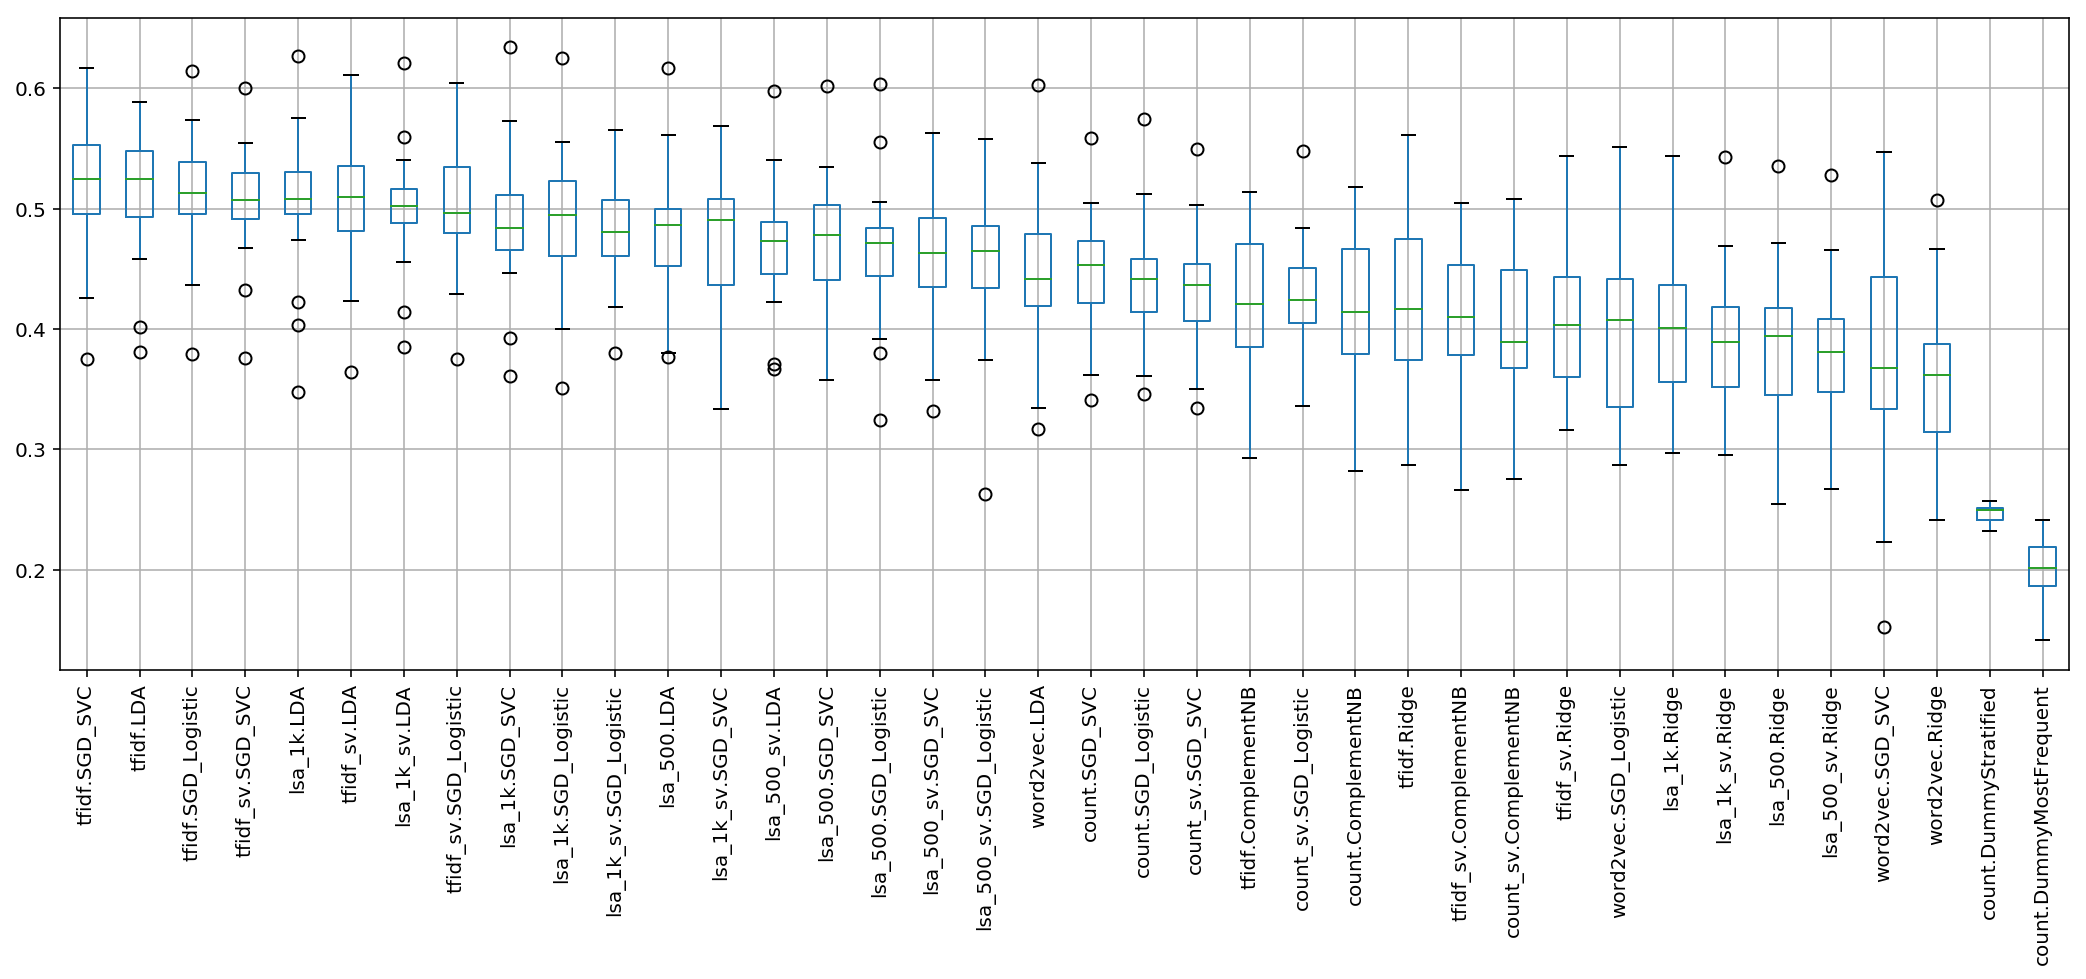

In [33]:
import matplotlib.pyplot as plt

df_test.drop([
    'tfidf.DummyStratified',
    'tfidf.DummyMostFrequent',
    'tfidf_sv.DummyStratified',
    'tfidf_sv.DummyMostFrequent',
    'count_sv.DummyStratified',
    'count_sv.DummyMostFrequent',
]).T.drop(['average']).boxplot(
    figsize=(18, 6), rot=90)

plt.show()

Let's save the models for future use.

In [34]:
results = conf['results']

In [35]:
from fgclassifier.utils import save_model

def clear_cache(model):
    if hasattr(model, 'steps'):
        for (name, step) in model.steps:
            clear_cache(step)
    if hasattr(model, 'cache'):
        model.cache = None
    # Drop the stopwords, as they are irrelevant for model predictions
    # but take a lot of space
    if hasattr(model, 'stop_words_'):
        model.stop_words_ = None
    return model

for name, model in results['models'].items():
    # skip unimportant models
    if 'QDA' in name:
        continue
    clear_cache(model)
    save_model(model)

clear_output()

## Conclusion

- `ComplementNB` performs much better than a simple MultinomialNB, because our class labels are mostly unbalanced.
- `LatentDirichletAllocation` topics as features are not suitable for our classification problem, as features are often collinear. They often fare no better than the dummy classifier where we simply return the most frequent labels.
- LSA (Latent Semantic Analysis, Tfidf + SVD) shows a much more promising outlook, especially when combined with Linear Discriminant Analysis or SVC.
- Find the right vocabulary (min_df and ngram range) is crucial. Throw away noises early often outperforms running dimension reduction later.
- Basically SVD makes each feature (component) more indendent with each other, making LDA and SVC easier to come up with good fittings.
- Tree based models are not particularly useful. But the results may be different had we tuned the tree structure more.

## Next Steps

Required:

- Tune hyperparamters for `ComplementNB`, `TruncatedSVD`, `LinearDiscriminantAnalysis` and `SVC`/`LinearSVC`. Try different kernel functions.
- Try over-/under-sampling since most of our classes are imbalanced. [Possible solution](https://imbalanced-learn.org/)
- Test some boosting methods, especially [xgboost](https://xgboost.readthedocs.io/en/latest/).
- Test word embedding as features.

Optional:

- Possibly use different classifier for different labels.
- Test two step predictions: first run binary prediction for "mentioned" vs "not mentioned", i.e., -2 vs (-1, 0, 1), then predict (-1, 0, 1).
    - This could happen as either [ClassifierChain](https://scikit-learn.org/stable/modules/multiclass.html#classifierchain) or separate steps.

In [ ]:
# model = results['models']['lsa_500_en_LDA']
# print(X_test[0:1].shape)
# probas = model.predict_proba(X_test[0:1])
# probas[0].shape

In [ ]:
# model.predict(X_test[0:1])